# TESS Atlas fit for TOI 467

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 467.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-467.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-467.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-467.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 467

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 467 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

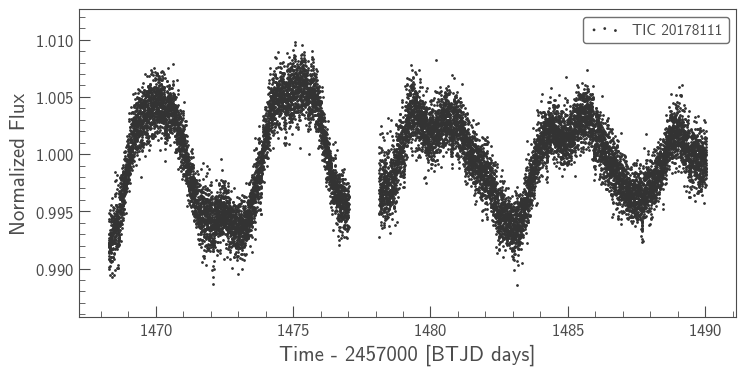

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -39568.29210815503 -> -36506.31700482347


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -25694.880084665765 -> -25290.494587394773


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -25290.494587394773 -> -25266.372288649185


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -25266.372288649185 -> -25266.371897288


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -25266.371897288 -> -25265.9157944174


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -25265.9157944174 -> -25265.9045554521


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -25265.9045554521 -> -25262.271618033603


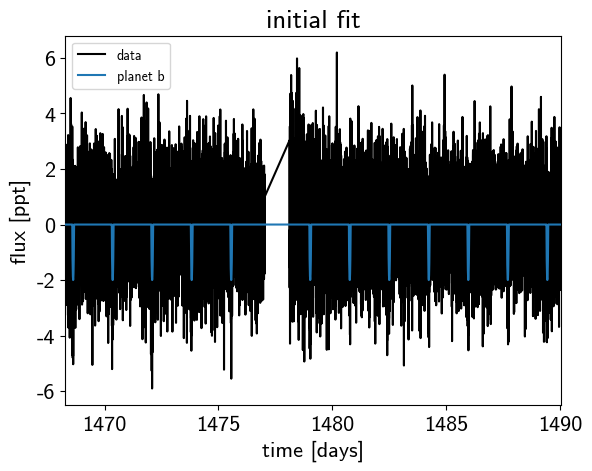

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 13.25draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:13,  7.01draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:16,  5.43draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.79draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:19,  4.45draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:16,  5.13draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:22,  3.74draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:18,  4.50draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:23,  3.53draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:19,  4.28draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:24,  3.26draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:23,  3.34draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:19,  4.08draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:22,  3.43draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:18,  4.15draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:21,  3.42draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:18,  4.09draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:24,  2.97draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:22,  3.15draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:21,  3.26draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:19,  3.42draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.85draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:19,  3.38draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:16,  3.81draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:19,  3.24draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.76draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:22,  2.77draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:20,  2.90draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:18,  3.07draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:15,  3.56draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:18,  2.91draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:15,  3.44draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:18,  2.82draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:16,  3.24draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:17,  2.85draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:15,  3.24draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:17,  2.78draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:14,  3.26draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:18,  2.60draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:14,  3.16draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:14,  3.01draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:12,  3.55draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:15,  2.78draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:13,  3.12draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:14,  2.77draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:14,  2.84draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:13,  2.85draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:13,  2.85draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:12,  2.97draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:12,  2.90draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:11,  2.99draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:10,  3.25draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:11,  2.94draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:09,  3.52draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:10,  2.82draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:20<00:09,  2.93draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:21<00:07,  3.54draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:21<00:09,  2.84draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:07,  3.40draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:09,  2.63draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:07,  3.14draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:22<00:08,  2.67draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:07,  2.98draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:23<00:07,  2.79draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:23<00:06,  2.92draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:06,  2.73draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:06,  2.99draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:24<00:05,  3.04draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:05,  2.80draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:25<00:04,  3.29draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:05,  2.62draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:04,  2.84draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:26<00:03,  3.47draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:03,  2.90draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:02,  3.11draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:02,  3.12draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:28<00:02,  2.90draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:28<00:01,  3.45draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:28<00:01,  3.13draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:29<00:01,  3.60draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:29<00:00,  3.22draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:29<00:00,  2.67draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:31<00:00,  1.31draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:33<00:00,  1.01draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:02, 43.74draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:09,  9.52draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:14,  6.41draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:23,  3.73draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:19,  4.56draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:25,  3.38draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:24,  3.48draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:23,  3.52draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:22,  3.52draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.92draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:18,  4.32draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:22,  3.47draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  4.09draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:19,  3.82draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:22,  3.28draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:19,  3.76draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:23,  2.98draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:19,  3.44draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:15,  4.28draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:19,  3.32draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:18,  3.45draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:15,  4.10draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:18,  3.29draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:17,  3.49draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:14,  4.08draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.29draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:14,  3.89draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:15,  3.56draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:15,  3.42draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:15,  3.50draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:14,  3.51draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:11<00:14,  3.52draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:13,  3.60draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:14,  3.28draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:12,  3.72draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:14,  3.16draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:12,  3.74draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:14,  3.09draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:12,  3.59draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:14<00:14,  2.99draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:12,  3.24draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:14,  2.82draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:12,  3.00draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:10,  3.45draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:16<00:08,  4.23draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:10,  3.28draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:17<00:09,  3.35draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:17<00:07,  3.95draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:08,  3.40draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:07,  4.02draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:18<00:06,  4.10draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:18<00:06,  3.96draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:07,  3.59draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:19<00:06,  3.99draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:19<00:06,  3.54draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:05,  4.12draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:06,  3.46draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:20<00:05,  3.98draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:20<00:04,  4.78draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:05,  3.52draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:21<00:04,  3.45draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:04,  3.51draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:22<00:03,  4.14draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:22<00:03,  3.95draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:22<00:02,  4.03draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.78draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:23<00:02,  3.98draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:23<00:02,  3.67draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:01,  3.94draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:01,  3.60draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  3.47draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  3.24draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:26<00:00,  1.45draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:28<00:00,  1.20draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:18,  2.59draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:57,  3.49draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<00:54,  3.69draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:46,  4.32draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:00<00:38,  5.18draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:48,  4.05draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:52,  3.71draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:53,  3.58draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:55,  3.46draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:53,  3.54draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:44,  4.27draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:54,  3.41draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:58,  3.16draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:46,  3.97draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<00:46,  3.93draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:36,  4.99draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:05<00:30,  5.81draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:05<00:25,  7.06draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:32,  5.31draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:06<00:29,  5.97draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:06<00:41,  4.21draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:07<00:41,  4.16draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:07<00:42,  4.00draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:07<00:36,  4.66draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:07<00:31,  5.38draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:07<00:31,  5.27draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:07<00:34,  4.91draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:08<00:38,  4.29draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:08<00:46,  3.52draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:08<00:40,  4.01draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:45,  3.60draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:09<00:35,  4.56draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:09<00:40,  3.90draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:09<00:30,  5.12draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:10<00:48,  3.24draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:10<00:37,  4.11draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:11<00:51,  2.97draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:11<00:41,  3.72draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:11<00:38,  3.93draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:11<00:36,  4.15draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:11<00:33,  4.43draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:12<00:38,  3.89draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:12<00:37,  3.92draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:12<00:40,  3.61draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:13<00:35,  4.13draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:13<00:45,  3.18draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:13<00:37,  3.82draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:14<00:40,  3.51draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:14<00:38,  3.63draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:15<00:35,  3.85draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:15<00:37,  3.60draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:16<00:36,  3.68draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:16<00:33,  3.92draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:16<00:33,  3.98draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:17<00:34,  3.82draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:17<00:32,  3.95draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:17<00:34,  3.66draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:18<00:42,  2.97draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:18<00:33,  3.73draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:18<00:43,  2.89draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:19<00:34,  3.55draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:19<00:26,  4.65draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:19<00:22,  5.45draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:19<00:26,  4.46draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:20<00:24,  4.69draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:20<00:21,  5.28draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:20<00:24,  4.74draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:21<00:34,  3.26draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:21<00:32,  3.38draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:22<00:30,  3.60draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:22<00:31,  3.51draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:22<00:30,  3.52draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:22<00:26,  4.06draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:23<00:26,  3.94draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:23<00:25,  4.12draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:23<00:21,  4.80draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:23<00:21,  4.72draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:24<00:25,  3.98draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:24<00:21,  4.67draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:24<00:20,  4.80draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:25<00:20,  4.66draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:25<00:21,  4.32draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:25<00:19,  4.65draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:26<00:20,  4.36draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:26<00:18,  4.85draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:26<00:16,  5.37draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:26<00:20,  4.26draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:27<00:27,  3.22draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:27<00:22,  3.80draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:28<00:21,  3.88draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:28<00:16,  4.96draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:28<00:19,  4.13draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:28<00:16,  4.81draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:29<00:17,  4.51draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:29<00:13,  5.43draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:29<00:14,  4.98draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:30<00:15,  4.59draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:30<00:15,  4.41draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:30<00:13,  5.12draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:30<00:14,  4.56draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:31<00:16,  3.98draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:31<00:15,  4.33draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:32<00:21,  2.96draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:32<00:21,  2.91draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:33<00:17,  3.44draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:33<00:16,  3.65draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:33<00:17,  3.23draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:34<00:14,  3.97draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:34<00:11,  4.75draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:34<00:12,  4.37draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:34<00:10,  5.09draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:34<00:09,  5.70draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:35<00:10,  5.01draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:35<00:09,  5.27draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:35<00:10,  4.50draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:36<00:13,  3.53draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:36<00:12,  3.72draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:36<00:11,  3.96draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:37<00:10,  4.05draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:37<00:08,  4.73draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:37<00:09,  4.16draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:38<00:11,  3.47draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:38<00:08,  4.23draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:38<00:08,  4.36draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:38<00:07,  4.40draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:39<00:07,  4.29draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:39<00:06,  4.63draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:40<00:11,  2.79draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:40<00:14,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:41<00:13,  2.09draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:41<00:10,  2.68draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:42<00:10,  2.54draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:42<00:12,  2.14draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:43<00:11,  2.12draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:43<00:13,  1.73draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:44<00:12,  1.85draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:45<00:14,  1.56draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:45<00:10,  2.02draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:46<00:08,  2.16draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:46<00:08,  2.03draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:47<00:07,  2.09draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:47<00:05,  2.67draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:47<00:04,  3.32draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:48<00:03,  3.72draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:48<00:04,  2.45draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:49<00:05,  1.98draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:49<00:04,  2.16draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:50<00:04,  1.92draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:51<00:04,  1.81draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:51<00:04,  1.68draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:52<00:03,  1.59draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:53<00:03,  1.51draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:54<00:02,  1.47draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:54<00:02,  1.44draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:55<00:01,  1.47draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:56<00:00,  1.48draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:56<00:00,  1.89draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:08, 44.48draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:13, 29.60draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:15, 25.93draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:00<00:14, 26.19draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:14, 27.21draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:00<00:14, 25.91draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:17, 22.20draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:01<00:16, 23.38draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:14, 24.89draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:14, 24.96draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:01<00:12, 28.32draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:01<00:13, 27.31draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:13, 26.73draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:01<00:12, 29.26draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:02<00:17, 19.80draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:02<00:20, 16.96draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:20, 16.91draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:02<00:19, 17.81draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:02<00:19, 17.50draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:03<00:17, 19.34draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:03<00:15, 20.85draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:03<00:29, 11.05draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:03<00:31, 10.23draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:04<00:28, 11.44draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:04<00:32,  9.82draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:04<00:28, 11.22draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:04<00:34,  9.32draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:04<00:29, 10.77draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:05<00:30, 10.24draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:05<00:26, 11.57draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:05<00:29, 10.39draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:06<00:40,  7.63draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:06<00:38,  7.83draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:06<00:37,  8.01draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:06<00:31,  9.48draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:06<00:30,  9.95draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:06<00:24, 12.15draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:07<00:22, 13.25draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:07<00:17, 16.36draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:07<00:15, 18.29draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:07<00:12, 21.80draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:07<00:11, 24.79draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:07<00:11, 24.00draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:07<00:09, 29.02draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:07<00:08, 30.68draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:08<00:20, 12.62draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:08<00:16, 15.11draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:09<00:18, 13.62draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:09<00:17, 14.33draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:09<00:14, 16.56draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:09<00:19, 12.83draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:09<00:19, 12.31draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:10<00:16, 14.46draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:10<00:15, 15.07draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:10<00:15, 15.54draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:10<00:13, 17.58draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:10<00:11, 20.57draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:10<00:12, 17.44draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:10<00:12, 17.91draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:10<00:10, 21.15draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:11<00:09, 21.76draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:11<00:09, 22.18draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:11<00:08, 23.52draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:11<00:09, 22.63draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:11<00:10, 19.04draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:11<00:10, 18.72draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:12<00:09, 19.65draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:12<00:09, 19.89draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:12<00:09, 20.11draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:12<00:08, 22.92draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:12<00:07, 24.40draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:12<00:06, 27.92draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:12<00:05, 30.31draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:13<00:05, 32.38draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:13<00:04, 32.90draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:13<00:05, 28.88draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:13<00:05, 30.28draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:13<00:04, 31.08draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:13<00:04, 33.62draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:13<00:03, 36.78draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:13<00:03, 37.36draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:14<00:03, 36.17draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:14<00:03, 33.71draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:14<00:03, 34.19draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:14<00:03, 37.92draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:14<00:02, 39.14draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:14<00:02, 35.15draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:14<00:03, 30.18draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:15<00:03, 31.18draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:15<00:03, 29.63draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:15<00:03, 27.07draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:15<00:04, 20.60draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:15<00:03, 23.27draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:15<00:03, 23.86draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:16<00:02, 25.57draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:16<00:02, 27.54draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:16<00:02, 31.31draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:16<00:01, 31.94draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:16<00:01, 31.58draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:16<00:01, 32.30draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:16<00:01, 31.21draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:16<00:01, 30.52draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:17<00:01, 28.86draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:17<00:01, 23.67draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:17<00:01, 24.14draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:17<00:01, 24.81draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:17<00:01, 24.98draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:17<00:01, 25.08draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:17<00:00, 27.12draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:17<00:00, 30.43draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:18<00:00, 31.36draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:18<00:00, 33.97draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:18<00:00, 33.80draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:18<00:00, 30.99draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:18<00:00, 21.77draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:17, 45.52draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:21, 37.16draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:23, 34.33draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:25, 30.81draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:28, 27.60draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:29, 26.71draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:29, 26.46draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:01<00:25, 30.17draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:23, 32.39draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:21, 35.70draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:01<00:20, 36.25draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:01<00:18, 40.42draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:01<00:18, 39.62draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:01<00:19, 39.01draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:01<00:17, 41.73draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:02<00:18, 38.76draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:02<00:29, 24.87draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:02<00:35, 20.40draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:02<00:36, 19.86draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:03<00:35, 20.40draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:37, 19.15draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:03<00:35, 19.94draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:03<00:32, 21.67draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:03<00:31, 22.30draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:03<00:32, 21.69draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:03<00:34, 19.95draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:04<00:29, 23.14draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:04<00:23, 28.89draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:04<00:21, 31.49draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:04<00:22, 30.29draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:04<00:22, 29.79draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:04<00:20, 33.23draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:04<00:16, 40.97draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:04<00:18, 35.76draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:05<00:18, 34.53draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:05<00:20, 30.91draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:05<00:23, 27.75draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:05<00:24, 25.92draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:05<00:22, 27.99draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:05<00:21, 29.30draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:06<00:18, 33.19draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:06<00:24, 25.72draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:06<00:24, 24.66draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:06<00:22, 26.98draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:06<00:20, 29.92draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:06<00:17, 34.05draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:06<00:14, 40.20draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:06<00:14, 40.57draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:07<00:13, 42.20draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:07<00:12, 45.82draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:07<00:11, 48.40draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:07<00:11, 47.00draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:07<00:13, 42.38draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:07<00:12, 43.04draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:07<00:13, 40.12draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:07<00:13, 41.82draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:08<00:14, 36.28draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:08<00:14, 36.20draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:08<00:14, 37.07draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:08<00:12, 42.37draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:08<00:11, 44.88draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:08<00:12, 40.68draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:08<00:12, 40.21draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:09<00:15, 33.33draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:09<00:15, 33.16draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:09<00:16, 30.31draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:09<00:16, 30.30draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:09<00:15, 31.52draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:09<00:15, 31.18draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:09<00:15, 31.43draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:09<00:14, 31.79draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:10<00:13, 34.16draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:10<00:14, 31.73draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:10<00:14, 31.94draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:10<00:13, 33.71draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:10<00:15, 29.29draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:10<00:14, 30.03draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:10<00:14, 30.97draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:11<00:13, 33.18draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:11<00:12, 35.85draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:11<00:12, 34.43draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:11<00:15, 27.34draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:11<00:17, 24.62draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:11<00:19, 21.28draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:12<00:23, 17.63draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:12<00:21, 19.38draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:12<00:17, 22.74draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:12<00:17, 23.33draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:12<00:14, 26.87draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:12<00:12, 31.13draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:12<00:11, 33.72draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:13<00:11, 33.44draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:13<00:11, 31.81draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:13<00:12, 30.58draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:13<00:13, 27.97draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:13<00:11, 31.71draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:13<00:10, 35.24draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:13<00:11, 29.87draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:14<00:11, 29.94draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:14<00:10, 33.65draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:14<00:09, 36.32draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:14<00:08, 38.80draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:14<00:07, 43.04draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:14<00:06, 47.30draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:14<00:06, 49.42draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:14<00:07, 39.20draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:15<00:06, 44.13draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:15<00:08, 36.63draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:15<00:08, 36.02draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:15<00:07, 37.30draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:15<00:07, 39.94draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:15<00:07, 36.43draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:15<00:07, 35.30draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:16<00:07, 36.91draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:16<00:07, 35.62draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:16<00:07, 34.06draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:16<00:09, 26.51draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:16<00:10, 24.12draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:16<00:10, 24.30draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:16<00:09, 26.38draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:17<00:10, 23.98draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:17<00:09, 24.27draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:17<00:10, 23.00draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:17<00:09, 23.51draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:17<00:09, 23.55draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:17<00:08, 26.70draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:17<00:08, 25.77draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:17<00:09, 24.32draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:18<00:08, 26.29draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:18<00:09, 22.99draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:18<00:10, 19.97draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:18<00:10, 20.82draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:18<00:10, 19.22draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:18<00:09, 21.61draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:19<00:08, 23.74draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:19<00:07, 24.42draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:19<00:07, 26.20draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:19<00:07, 25.70draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:19<00:08, 22.04draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:19<00:08, 21.29draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:19<00:08, 21.02draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:20<00:07, 23.51draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:20<00:06, 25.77draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:20<00:06, 27.61draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:20<00:06, 26.76draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:20<00:06, 24.30draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:20<00:07, 21.38draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:20<00:06, 22.94draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:21<00:06, 23.56draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:21<00:06, 22.41draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:21<00:06, 23.12draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:21<00:06, 22.79draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:21<00:05, 25.84draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:21<00:05, 23.92draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:21<00:05, 22.56draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:21<00:05, 23.20draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:22<00:05, 22.05draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:22<00:04, 24.38draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:22<00:04, 24.01draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:25<00:37,  3.07draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:26<00:42,  2.68draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:26<00:37,  3.00draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:27<00:39,  2.79draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:28<00:42,  2.54draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:28<00:33,  3.21draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:28<00:30,  3.43draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:28<00:28,  3.63draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:28<00:23,  4.37draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:28<00:19,  5.20draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:29<00:21,  4.85draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:29<00:19,  5.13draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:29<00:16,  5.92draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:29<00:18,  5.26draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:29<00:16,  5.91draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:29<00:14,  6.67draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:29<00:13,  7.10draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:30<00:12,  7.43draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:30<00:12,  7.68draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:30<00:10,  8.75draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:30<00:10,  8.60draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:30<00:10,  8.51draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:30<00:08,  9.97draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:30<00:07, 11.32draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:31<00:06, 13.45draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:31<00:06, 12.31draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:31<00:06, 11.88draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:31<00:06, 12.54draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:31<00:04, 15.50draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:32<00:06, 10.14draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:32<00:08,  8.27draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:32<00:09,  7.14draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:33<00:10,  5.87draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:33<00:09,  6.43draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:33<00:07,  7.88draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:33<00:06,  8.61draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:33<00:06,  8.50draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:34<00:05,  9.93draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:34<00:05, 10.22draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:34<00:05,  8.69draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:34<00:04, 10.11draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:34<00:04, 10.91draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:34<00:03, 12.15draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:35<00:02, 14.20draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:35<00:02, 16.29draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:35<00:01, 19.18draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:35<00:01, 20.94draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:35<00:01, 19.91draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:35<00:01, 18.81draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:36<00:01, 18.06draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:36<00:00, 18.76draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:36<00:00, 21.03draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:36<00:00, 19.40draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:36<00:00, 19.53draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:36<00:00, 21.27draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:36<00:00, 20.82draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:37<00:00, 21.72draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:07, 23.53draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:45, 26.55draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:39, 27.57draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<02:46, 26.40draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<02:42, 27.08draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<02:41, 27.07draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:00<03:02, 23.95draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<03:18, 22.04draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:01<03:03, 23.82draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<03:06, 23.41draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<03:20, 21.76draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:01<03:31, 20.64draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:01<03:08, 23.20draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:01<03:09, 23.03draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<03:44, 19.39draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:02<03:44, 19.39draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<03:12, 22.56draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:02<02:46, 26.06draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:02<02:37, 27.59draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:02<02:53, 24.93draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:49, 25.61draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<02:40, 26.91draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:03<02:32, 28.38draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:03<02:30, 28.79draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<02:16, 31.56draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:03<02:18, 31.14draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:03<02:19, 30.77draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:03<02:18, 31.11draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:03<02:10, 33.01draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:04<02:32, 28.09draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:04<03:24, 20.99draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<03:50, 18.64draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:04<03:49, 18.65draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:04<03:54, 18.23draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:04<03:39, 19.47draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:05<03:24, 20.92draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:05<03:01, 23.49draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:05<02:37, 27.18draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:05<03:04, 23.05draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:05<03:20, 21.29draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:05<02:59, 23.66draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:06<03:06, 22.86draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:06<02:47, 25.32draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:06<02:48, 25.20draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:06<02:31, 28.08draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:06<02:28, 28.47draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:06<02:24, 29.31draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:06<02:14, 31.43draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:06<02:13, 31.55draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:06<02:00, 35.00draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:07<02:01, 34.68draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:07<02:05, 33.69draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:07<02:08, 32.81draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:07<02:11, 32.02draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:07<02:15, 31.00draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:07<02:10, 32.06draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:07<02:05, 33.48draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:07<02:05, 33.46draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:08<02:04, 33.72draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:08<02:08, 32.47draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:08<01:57, 35.54draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:08<01:55, 36.00draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:08<01:50, 37.64draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:08<02:22, 29.20draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:09<02:53, 23.98draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:09<03:00, 23.00draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:09<02:47, 24.81draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:09<02:33, 27.01draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:09<02:29, 27.76draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:09<02:31, 27.32draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:09<02:19, 29.71draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:10<02:37, 26.14draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:10<02:50, 24.16draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:10<02:52, 23.95draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:10<02:59, 22.96draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:10<02:39, 25.87draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:10<02:43, 25.14draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:10<02:59, 22.84draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:11<02:56, 23.22draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:11<03:13, 21.17draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:11<03:19, 20.54draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:11<03:07, 21.85draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:11<03:21, 20.34draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:11<03:12, 21.28draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:11<02:40, 25.48draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:12<02:43, 24.99draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:12<02:40, 25.33draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:12<02:36, 26.03draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:12<02:43, 24.87draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:12<02:25, 27.90draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:12<02:16, 29.71draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:12<02:04, 32.72draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:12<01:54, 35.28draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:13<01:50, 36.79draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:13<01:40, 40.18draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:13<01:51, 36.11draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:13<01:54, 35.08draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:13<01:57, 34.28draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:13<02:14, 29.82draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:13<02:31, 26.50draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:14<02:38, 25.35draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:14<02:44, 24.48draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:14<02:50, 23.48draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:14<02:47, 23.95draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:14<02:54, 23.00draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:14<02:57, 22.54draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:14<03:09, 21.10draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:15<03:18, 20.13draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:15<02:55, 22.71draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:15<02:51, 23.22draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:15<02:43, 24.39draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:15<02:41, 24.74draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:15<02:44, 24.12draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:15<02:57, 22.47draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:15<02:49, 23.48draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:16<02:41, 24.63draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:16<02:29, 26.60draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:16<02:33, 25.88draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:16<02:18, 28.62draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:16<01:55, 34.13draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:16<02:19, 28.28draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:16<02:21, 27.94draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:17<02:15, 29.03draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:17<02:44, 23.98draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:17<02:53, 22.66draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:17<02:57, 22.18draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:17<02:59, 21.87draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:17<03:04, 21.28draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:18<03:44, 17.44draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:18<03:59, 16.38draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:18<04:00, 16.28draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:18<04:03, 16.06draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:18<03:36, 18.07draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:18<03:30, 18.59draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:18<03:06, 20.95draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:18<02:45, 23.65draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:19<02:25, 26.73draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:19<02:27, 26.49draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:19<02:21, 27.41draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:19<02:30, 25.87draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:19<02:14, 28.83draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:19<02:05, 31.02draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:19<01:54, 33.87draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:19<01:46, 36.21draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:20<01:48, 35.70draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:20<01:53, 34.04draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:20<01:58, 32.62draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:20<01:54, 33.71draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:20<02:01, 31.75draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:20<02:03, 31.14draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:20<02:05, 30.58draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:20<02:03, 31.05draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:21<02:04, 30.82draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:21<01:57, 32.71draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:21<02:09, 29.62draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:21<02:11, 29.16draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:21<02:23, 26.68draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:21<02:30, 25.31draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:21<02:35, 24.59draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:22<02:32, 24.91draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:22<02:34, 24.57draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:22<02:28, 25.69draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:22<02:27, 25.75draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:22<02:21, 26.87draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:22<02:15, 27.95draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:22<01:59, 31.65draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:22<01:52, 33.75draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:22<01:41, 37.16draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:23<01:32, 40.61draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:23<01:33, 40.47draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:23<01:42, 36.69draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:23<01:49, 34.23draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:23<01:43, 36.27draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:23<02:05, 29.79draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:23<02:32, 24.58draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:24<02:25, 25.79draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:24<03:17, 18.94draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:24<03:13, 19.27draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:24<03:08, 19.77draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:24<03:08, 19.80draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:24<03:17, 18.88draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:25<03:21, 18.52draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:25<03:13, 19.20draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:25<03:11, 19.43draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:25<03:20, 18.54draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:25<03:06, 19.91draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:25<04:07, 15.02draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:26<03:57, 15.60draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:26<05:02, 12.27draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:26<04:56, 12.49draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:26<05:13, 11.80draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:26<05:09, 11.96draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:27<05:22, 11.49draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:27<05:34, 11.06draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:27<05:45, 10.69draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:27<04:57, 12.40draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:27<05:11, 11.84draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:27<04:51, 12.66draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:27<04:44, 12.95draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:28<04:01, 15.27draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:28<03:13, 19.06draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:28<05:12, 11.75draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:28<05:41, 10.76draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:29<05:37, 10.87draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:29<05:21, 11.42draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:29<08:04,  7.57draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:29<07:58,  7.66draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:30<10:06,  6.04draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:30<11:50,  5.15draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:31<14:59,  4.07draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:31<15:28,  3.95draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:31<13:20,  4.57draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:31<11:34,  5.27draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:31<10:25,  5.85draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:31<09:43,  6.26draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:32<10:31,  5.79draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:32<09:45,  6.25draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:32<07:43,  7.87draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:32<08:26,  7.21draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:32<07:35,  8.01draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:33<07:17,  8.34draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:33<06:13,  9.76draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:33<06:59,  8.69draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:33<06:02, 10.04draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:33<05:56, 10.21draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:34<05:20, 11.33draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:34<05:08, 11.79draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:34<04:42, 12.85draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:34<04:41, 12.90draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [00:34<04:36, 13.10draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:34<04:53, 12.37draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:34<04:28, 13.51draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:35<05:24, 11.15draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:35<07:21,  8.20draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:35<08:38,  6.97draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:36<07:47,  7.74draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:36<07:10,  8.40draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:36<06:13,  9.67draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [00:36<05:11, 11.57draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:36<04:33, 13.16draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:36<04:06, 14.62draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:36<03:51, 15.57draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:37<03:24, 17.59draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:37<03:07, 19.19draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:37<04:13, 14.15draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [00:38<13:11,  4.54draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:39<17:43,  3.37draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:40<30:18,  1.97draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:42<37:55,  1.58draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:42<31:05,  1.92draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:43<42:20,  1.41draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:44<45:16,  1.32draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:44<34:52,  1.71draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:45<42:39,  1.40draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:46<47:02,  1.27draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:47<40:51,  1.46draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:48<36:58,  1.61draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:48<34:41,  1.72draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:49<29:17,  2.03draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:49<31:17,  1.90draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:50<30:06,  1.98draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [00:50<28:48,  2.07draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:50<24:30,  2.43draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [00:51<24:11,  2.46draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:51<20:56,  2.84draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:52<23:01,  2.58draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [00:52<20:00,  2.97draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:52<18:12,  3.26draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:52<16:24,  3.62draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:53<16:04,  3.69draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:53<15:58,  3.72draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:53<12:26,  4.77draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:53<10:49,  5.48draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:53<09:30,  6.24draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:53<08:24,  7.05draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:54<07:59,  7.41draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [00:54<06:36,  8.97draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:54<06:29,  9.11draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:54<05:50, 10.11draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:54<05:22, 11.01draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:54<04:35, 12.86draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:55<05:05, 11.57draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:55<06:03,  9.73draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:55<05:29, 10.74draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:55<05:19, 11.06draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:55<05:25, 10.86draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:55<04:59, 11.80draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:56<06:02,  9.73draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:56<06:46,  8.68draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:56<06:39,  8.82draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:56<06:32,  8.98draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:57<06:10,  9.51draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:57<05:38, 10.38draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:57<05:32, 10.57draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:57<06:13,  9.41draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:57<06:47,  8.61draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:57<06:38,  8.80draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:58<05:59,  9.77draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:58<05:23, 10.84draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:58<05:02, 11.61draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:58<05:24, 10.81draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:58<05:18, 10.99draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:58<04:38, 12.57draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:59<08:43,  6.68draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:59<09:35,  6.07draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [01:00<10:05,  5.77draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:00<10:31,  5.54draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:00<09:03,  6.42draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [01:00<09:46,  5.95draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [01:00<10:34,  5.50draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:01<08:55,  6.51draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [01:01<07:49,  7.42draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [01:01<07:31,  7.72draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [01:01<07:34,  7.66draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:01<07:41,  7.54draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [01:01<07:36,  7.63draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [01:02<06:41,  8.67draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [01:02<05:52,  9.85draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:02<05:35, 10.35draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [01:02<05:03, 11.45draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [01:02<04:23, 13.16draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [01:02<04:54, 11.78draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [01:03<04:41, 12.29draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [01:03<03:53, 14.82draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [01:03<05:09, 11.19draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [01:04<12:01,  4.79draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [01:06<20:55,  2.75draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:06<25:11,  2.28draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [01:08<54:04,  1.06draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:09<49:13,  1.17draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [01:11<1:00:37,  1.05s/draws]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:11<48:07,  1.19draws/s]  

Sampling 2 chains:  22%|██▏       | 956/4404 [01:13<1:03:06,  1.10s/draws]

Sampling 2 chains:  22%|██▏       | 958/4404 [01:14<58:11,  1.01s/draws]  

Sampling 2 chains:  22%|██▏       | 959/4404 [01:15<48:33,  1.18draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [01:16<57:44,  1.01s/draws]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:17<54:31,  1.05draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [01:17<39:59,  1.43draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:17<35:22,  1.62draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [01:18<41:00,  1.40draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:19<42:22,  1.35draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [01:19<31:40,  1.81draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:20<33:40,  1.70draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [01:20<32:37,  1.76draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [01:21<32:08,  1.78draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [01:22<31:56,  1.79draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:22<26:09,  2.19draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [01:23<32:25,  1.76draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:23<37:43,  1.52draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [01:24<31:00,  1.84draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:24<24:06,  2.37draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [01:24<24:49,  2.30draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:25<24:33,  2.32draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [01:25<22:00,  2.59draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:25<19:03,  3.00draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [01:25<17:11,  3.32draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [01:26<15:39,  3.64draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [01:26<14:34,  3.91draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [01:26<12:10,  4.68draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:26<12:14,  4.65draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [01:27<12:02,  4.73draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:27<11:48,  4.82draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [01:27<09:59,  5.70draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [01:27<09:05,  6.26draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:27<08:12,  6.94draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [01:27<07:29,  7.60draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [01:27<06:26,  8.82draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [01:28<05:41,  9.99draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [01:28<05:19, 10.65draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [01:28<05:22, 10.57draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [01:28<04:52, 11.62draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [01:28<04:41, 12.06draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [01:28<04:06, 13.80draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [01:28<03:52, 14.61draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [01:29<03:51, 14.66draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [01:29<03:47, 14.87draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:29<03:58, 14.23draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [01:29<03:30, 16.06draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [01:29<03:18, 17.05draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:29<03:35, 15.66draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:29<03:44, 15.08draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:30<03:24, 16.49draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:30<02:53, 19.39draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:30<03:01, 18.61draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:30<04:08, 13.53draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:30<03:40, 15.28draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:31<07:04,  7.91draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:32<11:57,  4.68draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:32<12:29,  4.48draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [01:32<12:24,  4.51draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:33<10:20,  5.40draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [01:33<10:10,  5.49draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:33<08:49,  6.33draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [01:33<08:32,  6.54draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:33<06:44,  8.28draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:34<07:00,  7.95draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:34<07:13,  7.71draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [01:34<06:44,  8.26draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:34<06:13,  8.94draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:34<05:48,  9.58draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:35<04:38, 11.96draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:35<04:41, 11.84draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:35<04:00, 13.81draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:35<03:54, 14.17draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:35<04:09, 13.30draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:35<04:03, 13.64draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [01:35<03:36, 15.35draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [01:36<03:38, 15.19draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:36<03:37, 15.22draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [01:36<03:14, 17.01draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:36<03:17, 16.74draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:36<03:19, 16.57draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:36<03:30, 15.75draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [01:36<03:35, 15.37draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:37<03:29, 15.79draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [01:37<03:20, 16.49draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:37<03:03, 18.01draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:37<03:37, 15.17draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [01:37<03:57, 13.89draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:37<04:24, 12.46draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:37<04:14, 12.94draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:38<03:38, 15.07draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [01:38<03:09, 17.35draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [01:38<02:49, 19.30draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [01:38<02:43, 20.09draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [01:38<02:52, 19.01draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:38<02:58, 18.37draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [01:38<02:43, 20.03draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [01:39<02:48, 19.39draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [01:39<02:58, 18.25draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:39<02:47, 19.46draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:39<02:34, 21.14draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:39<03:14, 16.70draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:39<03:18, 16.35draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:40<03:21, 16.16draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:40<03:04, 17.64draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [01:40<03:35, 15.04draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [01:40<04:28, 12.08draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:40<04:41, 11.52draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [01:40<04:52, 11.07draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [01:41<04:20, 12.43draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:41<04:26, 12.14draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [01:41<04:30, 11.96draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:41<04:14, 12.71draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:41<04:24, 12.20draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [01:41<04:31, 11.88draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:42<04:43, 11.39draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:42<04:24, 12.18draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:42<04:08, 12.97draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:42<04:10, 12.84draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [01:42<03:45, 14.26draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:42<04:00, 13.35draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:43<03:50, 13.92draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:43<03:55, 13.63draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:43<04:42, 11.35draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:43<04:02, 13.21draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:43<03:48, 13.99draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [01:43<03:40, 14.53draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:44<03:56, 13.50draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:44<03:34, 14.88draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [01:44<03:51, 13.81draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:44<04:04, 13.03draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:44<04:24, 12.06draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:44<03:51, 13.78draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [01:44<04:06, 12.90draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:45<04:22, 12.12draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [01:45<04:33, 11.65draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [01:45<04:19, 12.27draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:45<04:04, 12.99draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:45<03:55, 13.49draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:45<03:36, 14.66draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:46<04:05, 12.93draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [01:46<03:41, 14.32draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:46<03:46, 14.00draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:46<04:09, 12.69draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [01:46<04:32, 11.63draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:46<04:12, 12.51draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:47<03:40, 14.32draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:47<04:05, 12.88draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [01:47<04:13, 12.46draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [01:47<04:14, 12.39draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [01:47<04:21, 12.03draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:47<04:20, 12.08draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [01:47<03:42, 14.15draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:48<03:56, 13.29draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [01:48<04:05, 12.80draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:48<03:57, 13.22draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:48<04:34, 11.43draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:48<04:54, 10.66draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [01:49<04:05, 12.76draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:49<03:48, 13.68draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:49<03:41, 14.09draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:49<03:40, 14.15draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:49<03:23, 15.37draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [01:49<03:08, 16.52draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:49<03:29, 14.87draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [01:50<03:39, 14.19draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:50<03:10, 16.37draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [01:50<03:00, 17.22draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [01:50<02:49, 18.27draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:50<02:50, 18.23draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [01:50<03:29, 14.79draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [01:51<04:54, 10.54draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [01:51<05:00, 10.29draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [01:51<05:05, 10.13draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [01:51<05:09, 10.00draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:52<06:12,  8.29draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:52<06:10,  8.33draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:52<05:49,  8.82draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:52<05:27,  9.43draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [01:52<05:06, 10.06draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:53<05:38,  9.11draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:53<05:57,  8.63draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [01:53<05:50,  8.79draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [01:53<05:01, 10.21draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:53<04:12, 12.16draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [01:53<04:18, 11.87draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:54<04:20, 11.80draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:54<03:46, 13.52draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [01:54<04:19, 11.81draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [01:54<04:01, 12.68draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:54<03:44, 13.61draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:54<04:11, 12.15draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [01:55<04:31, 11.25draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:55<04:38, 10.96draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [01:55<04:33, 11.17draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:55<04:57, 10.25draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [01:55<04:45, 10.67draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [01:55<04:24, 11.51draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [01:56<05:09,  9.84draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:56<05:20,  9.50draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [01:56<05:15,  9.64draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:56<05:08,  9.84draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:57<05:09,  9.80draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:57<05:09,  9.80draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [01:57<04:39, 10.86draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [01:57<04:36, 10.97draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:57<04:41, 10.75draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [01:57<04:00, 12.57draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:58<04:11, 12.01draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [01:58<03:53, 12.93draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [01:58<03:52, 12.98draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:58<04:30, 11.14draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [01:58<04:05, 12.30draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [01:58<04:07, 12.18draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:59<04:19, 11.59draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [01:59<04:23, 11.42draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:59<03:47, 13.20draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [01:59<03:39, 13.72draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [01:59<03:33, 14.08draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:59<03:23, 14.72draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:59<03:21, 14.86draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [02:00<03:27, 14.43draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [02:00<03:36, 13.84draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [02:00<03:03, 16.34draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [02:00<02:47, 17.81draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [02:00<03:12, 15.54draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [02:00<03:02, 16.35draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [02:01<03:11, 15.60draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [02:01<03:19, 14.95draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [02:01<03:16, 15.12draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [02:01<02:43, 18.22draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [02:01<02:17, 21.62draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [02:01<02:34, 19.15draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [02:02<05:22,  9.17draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [02:03<12:31,  3.94draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [02:04<15:06,  3.26draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [02:04<11:45,  4.19draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [02:04<10:15,  4.80draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [02:05<11:36,  4.24draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [02:05<16:23,  3.00draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [02:06<18:32,  2.65draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [02:06<18:33,  2.65draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [02:07<22:12,  2.21draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [02:08<26:57,  1.82draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [02:08<29:32,  1.66draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [02:09<25:26,  1.93draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [02:09<28:17,  1.73draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [02:10<25:00,  1.96draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [02:10<27:33,  1.78draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [02:11<26:14,  1.87draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [02:11<26:46,  1.83draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [02:12<25:04,  1.95draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [02:13<25:32,  1.92draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [02:14<25:22,  1.93draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [02:15<21:42,  2.25draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [02:15<19:01,  2.57draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [02:15<16:53,  2.89draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [02:15<15:38,  3.12draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [02:16<14:34,  3.35draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [02:16<14:08,  3.45draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [02:16<17:36,  2.77draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [02:17<15:49,  3.08draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [02:17<15:03,  3.24draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [02:17<16:48,  2.90draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [02:17<14:57,  3.26draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [02:18<15:46,  3.09draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [02:18<18:05,  2.69draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [02:19<14:35,  3.33draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [02:19<14:09,  3.44draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [02:19<14:14,  3.41draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [02:19<11:52,  4.09draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [02:20<12:08,  4.00draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [02:20<12:12,  3.97draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [02:20<12:04,  4.02draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [02:20<10:29,  4.63draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [02:21<09:36,  5.05draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [02:21<08:16,  5.86draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [02:21<06:20,  7.63draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [02:21<07:00,  6.91draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [02:22<08:34,  5.64draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [02:22<07:30,  6.43draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [02:22<07:32,  6.41draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [02:22<07:20,  6.58draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [02:22<08:00,  6.02draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [02:23<08:49,  5.47draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [02:23<07:46,  6.21draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [02:23<07:23,  6.52draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [02:23<07:02,  6.85draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [02:23<05:48,  8.30draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [02:23<04:36, 10.44draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [02:23<04:40, 10.27draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [02:24<04:06, 11.68draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [02:24<03:55, 12.23draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [02:24<05:29,  8.73draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [02:24<05:38,  8.49draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [02:25<05:47,  8.27draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [02:25<05:50,  8.19draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [02:25<05:54,  8.10draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [02:25<05:57,  8.03draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [02:25<05:57,  8.02draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [02:26<06:58,  6.86draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [02:26<06:43,  7.11draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [02:26<05:34,  8.55draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [02:26<04:56,  9.64draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [02:26<05:02,  9.46draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [02:26<04:24, 10.81draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [02:27<04:18, 11.06draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [02:27<04:26, 10.71draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [02:27<03:47, 12.56draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [02:27<03:45, 12.61draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [02:27<03:30, 13.54draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [02:27<03:33, 13.34draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [02:28<03:06, 15.27draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [02:28<02:49, 16.78draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [02:28<02:46, 17.04draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [02:28<02:36, 18.16draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [02:28<02:42, 17.43draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [02:28<02:36, 18.12draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [02:28<02:25, 19.49draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [02:28<02:18, 20.34draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [02:29<02:14, 21.04draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [02:29<02:25, 19.32draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [02:29<02:17, 20.45draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [02:29<02:11, 21.39draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [02:29<02:07, 22.08draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [02:29<01:55, 24.27draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [02:29<01:50, 25.37draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [02:30<01:48, 25.89draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [02:30<01:35, 29.33draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [02:30<01:24, 32.97draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [02:30<01:21, 34.34draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [02:30<01:17, 35.89draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [02:30<01:21, 34.10draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [02:30<01:22, 33.51draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [02:30<01:15, 36.75draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [02:31<01:11, 38.55draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [02:31<01:20, 34.26draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [02:31<01:24, 32.58draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [02:31<01:18, 35.09draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:31<01:23, 32.86draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [02:31<01:20, 34.07draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [02:31<01:12, 37.41draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [02:31<01:23, 32.65draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [02:32<01:26, 31.38draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [02:32<01:19, 34.27draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [02:32<01:18, 34.65draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:32<01:17, 35.11draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:32<01:22, 32.70draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [02:32<01:20, 33.56draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [02:32<01:17, 34.84draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [02:32<01:24, 31.88draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [02:33<01:27, 30.60draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [02:33<01:16, 34.99draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:33<01:15, 35.39draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:33<01:20, 33.29draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [02:33<01:15, 35.42draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [02:33<01:12, 36.82draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [02:33<01:10, 37.68draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [02:33<01:09, 37.94draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [02:34<01:13, 35.94draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [02:34<01:11, 36.86draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [02:34<01:09, 38.15draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [02:34<01:04, 40.68draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [02:34<01:09, 37.91draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [02:34<01:12, 36.29draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:34<01:06, 39.25draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [02:34<01:19, 32.73draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [02:35<01:25, 30.44draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [02:35<01:26, 30.03draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [02:35<01:39, 26.16draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [02:35<01:36, 26.99draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:35<01:28, 29.48draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [02:35<01:17, 33.63draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [02:36<01:32, 27.93draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [02:36<01:29, 28.94draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:36<01:17, 33.11draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [02:36<01:08, 37.63draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:36<01:08, 37.67draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [02:36<01:19, 32.17draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [02:36<01:13, 34.71draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [02:37<01:29, 28.53draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [02:37<01:59, 21.39draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [02:37<02:11, 19.40draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [02:37<02:10, 19.55draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [02:37<02:20, 18.05draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [02:38<02:30, 16.88draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:38<02:27, 17.20draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [02:38<02:08, 19.65draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [02:38<02:12, 19.05draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [02:38<02:11, 19.15draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [02:38<02:20, 17.98draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [02:38<02:26, 17.16draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [02:39<02:31, 16.62draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [02:39<03:00, 13.98draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [02:39<02:45, 15.20draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [02:39<02:42, 15.48draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [02:39<02:19, 17.97draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [02:39<02:20, 17.77draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [02:40<02:27, 16.98draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [02:40<02:05, 19.86draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [02:40<02:05, 19.88draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:40<01:50, 22.45draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [02:40<01:50, 22.58draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [02:40<01:48, 23.01draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [02:40<01:38, 25.21draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [02:40<01:59, 20.81draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [02:41<02:04, 19.91draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [02:41<02:01, 20.39draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [02:41<02:09, 19.02draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [02:41<02:15, 18.23draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [02:41<02:10, 18.91draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [02:41<02:11, 18.70draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [02:42<02:10, 18.82draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [02:42<02:12, 18.55draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [02:42<02:01, 20.18draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [02:42<01:50, 22.15draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [02:42<02:04, 19.58draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [02:42<02:24, 16.92draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [02:42<02:04, 19.59draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [02:43<02:16, 17.82draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [02:43<02:04, 19.61draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [02:43<02:02, 19.93draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [02:43<01:58, 20.42draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [02:43<02:05, 19.39draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [02:44<02:34, 15.73draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [02:44<02:20, 17.27draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:44<02:25, 16.65draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [02:44<02:35, 15.57draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [02:44<02:38, 15.25draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [02:44<02:12, 18.21draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [02:44<02:12, 18.19draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [02:45<02:20, 17.05draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [02:45<02:02, 19.60draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [02:45<02:03, 19.47draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [02:45<01:50, 21.68draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [02:45<01:56, 20.57draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [02:45<02:01, 19.69draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [02:45<01:56, 20.44draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [02:46<01:58, 20.17draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:46<01:46, 22.27draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [02:46<01:52, 21.07draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [02:46<01:43, 22.91draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [02:46<01:49, 21.70draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [02:46<01:54, 20.73draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [02:46<01:57, 20.19draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [02:47<01:58, 19.99draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [02:47<01:56, 20.22draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [02:47<01:46, 22.11draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [02:47<01:36, 24.45draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [02:47<01:28, 26.42draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [02:47<01:33, 25.20draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [02:47<01:37, 23.94draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [02:47<01:37, 24.02draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [02:48<01:33, 25.09draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [02:48<01:52, 20.78draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [02:48<01:56, 19.99draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [02:48<01:42, 22.69draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [02:48<02:12, 17.48draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [02:49<02:08, 18.01draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [02:49<01:52, 20.64draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [02:49<02:10, 17.66draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [02:49<02:50, 13.53draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [02:49<02:43, 14.11draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [02:50<02:31, 15.16draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [02:50<02:31, 15.17draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [02:50<02:49, 13.57draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [02:50<02:44, 13.91draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [02:50<02:13, 17.14draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [02:50<02:58, 12.82draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [02:51<02:38, 14.41draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [02:51<02:59, 12.74draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [02:51<02:46, 13.67draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [02:51<02:38, 14.42draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [02:51<02:32, 14.93draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [02:51<02:28, 15.27draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [02:51<02:19, 16.24draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [02:52<02:09, 17.52draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [02:52<02:09, 17.54draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [02:52<02:09, 17.53draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [02:52<01:53, 19.93draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [02:52<01:37, 23.10draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [02:52<01:31, 24.50draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [02:52<01:43, 21.67draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [02:52<01:42, 21.86draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [02:53<01:41, 22.05draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [02:53<01:59, 18.84draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [02:53<02:01, 18.47draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [02:53<02:08, 17.43draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:53<01:58, 18.87draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [02:53<01:56, 19.17draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [02:53<02:07, 17.48draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [02:54<02:24, 15.47draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [02:54<02:32, 14.57draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [02:54<02:26, 15.17draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [02:54<02:26, 15.19draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [02:54<02:17, 16.07draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [02:54<02:08, 17.25draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [02:55<02:17, 16.12draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [02:55<02:17, 16.04draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [02:55<02:54, 12.67draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [02:55<02:40, 13.72draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [02:55<02:14, 16.35draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [02:55<02:01, 18.16draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [02:56<02:21, 15.54draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [02:56<02:04, 17.59draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [02:56<02:04, 17.58draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [02:56<02:09, 16.90draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [02:56<01:52, 19.38draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [02:56<02:01, 17.97draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [02:57<01:54, 18.95draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [02:57<01:56, 18.59draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [02:57<02:02, 17.78draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [02:57<02:06, 17.21draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [02:57<01:57, 18.38draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [02:57<02:23, 15.05draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [02:58<02:06, 17.08draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [02:58<02:14, 16.11draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [02:58<02:04, 17.33draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [02:58<01:55, 18.58draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [02:58<01:53, 18.88draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [02:58<01:45, 20.30draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [02:58<01:40, 21.29draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [02:58<01:31, 23.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [02:59<01:22, 25.97draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [02:59<01:24, 25.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:59<01:19, 26.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [02:59<01:22, 25.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [02:59<01:25, 24.92draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [02:59<01:33, 22.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [02:59<01:28, 23.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [03:00<01:22, 25.63draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [03:00<01:30, 23.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [03:00<01:36, 21.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [03:00<01:26, 24.37draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [03:00<01:20, 26.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [03:00<01:12, 28.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [03:00<01:12, 28.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [03:00<01:03, 32.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [03:01<00:57, 35.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [03:01<00:55, 37.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [03:01<00:55, 37.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [03:01<00:52, 39.40draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [03:01<00:53, 38.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [03:01<00:56, 36.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [03:01<01:03, 32.54draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [03:01<01:05, 31.05draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [03:02<01:12, 28.30draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [03:02<01:11, 28.49draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [03:02<01:16, 26.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [03:02<01:16, 26.51draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [03:02<01:17, 26.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [03:02<01:25, 23.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [03:02<01:18, 25.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [03:03<01:23, 24.26draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [03:03<01:39, 20.17draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [03:03<01:37, 20.73draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [03:03<01:36, 20.92draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [03:03<01:33, 21.41draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [03:03<01:21, 24.64draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [03:03<01:16, 26.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [03:04<01:12, 27.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [03:04<01:11, 27.84draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [03:04<01:15, 26.44draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [03:04<01:13, 27.11draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [03:04<01:11, 27.57draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [03:04<01:10, 28.03draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [03:04<01:04, 30.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [03:04<01:10, 28.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [03:05<01:01, 32.12draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [03:05<01:00, 32.34draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [03:05<01:02, 31.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [03:05<00:56, 34.76draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [03:05<00:53, 36.35draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [03:05<00:53, 36.62draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [03:05<00:52, 36.79draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [03:05<00:51, 37.52draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [03:05<00:52, 37.07draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [03:06<01:02, 30.93draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [03:06<00:53, 36.02draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [03:06<00:52, 36.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [03:06<00:55, 34.48draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [03:06<00:54, 35.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [03:06<00:57, 33.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [03:06<00:59, 31.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [03:07<01:00, 31.52draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [03:07<00:55, 34.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [03:07<01:00, 31.36draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [03:07<00:59, 31.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [03:07<00:56, 33.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [03:07<00:53, 35.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [03:07<00:50, 36.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [03:07<00:52, 35.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [03:08<00:51, 36.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [03:08<00:53, 34.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [03:08<00:51, 36.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [03:08<00:49, 37.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [03:08<00:50, 36.41draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [03:08<00:48, 37.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [03:08<00:46, 39.13draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [03:08<00:49, 37.23draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [03:09<00:46, 39.47draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [03:09<00:47, 38.15draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [03:09<00:52, 34.37draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [03:09<00:55, 32.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [03:09<00:54, 33.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [03:09<00:54, 33.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [03:09<00:53, 33.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [03:09<00:50, 35.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [03:10<00:49, 36.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [03:10<00:52, 34.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [03:10<00:49, 36.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [03:10<00:50, 35.36draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [03:10<00:52, 33.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [03:10<00:54, 32.66draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [03:10<00:53, 32.91draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [03:10<00:50, 34.97draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [03:11<00:46, 37.75draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [03:11<00:47, 36.82draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [03:11<00:47, 36.82draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [03:11<00:46, 37.19draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [03:11<00:49, 35.32draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [03:11<00:57, 30.13draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [03:11<01:02, 27.70draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [03:11<00:56, 30.26draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [03:12<00:55, 31.02draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [03:12<01:09, 24.57draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [03:12<01:04, 26.61draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [03:12<00:58, 29.31draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [03:12<00:59, 28.46draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [03:12<01:12, 23.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [03:13<01:07, 25.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [03:13<01:07, 25.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [03:13<01:06, 25.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [03:13<00:59, 28.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [03:13<00:56, 29.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [03:13<01:02, 26.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [03:13<01:10, 23.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [03:14<01:13, 22.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [03:14<01:21, 20.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [03:14<01:18, 21.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [03:14<01:11, 23.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [03:14<01:09, 23.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [03:14<01:04, 25.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [03:14<01:05, 25.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [03:14<01:05, 25.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [03:15<01:00, 27.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [03:15<01:02, 26.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [03:15<00:59, 27.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [03:15<00:54, 30.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [03:15<00:50, 32.20draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [03:15<00:46, 35.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [03:15<00:45, 35.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [03:15<00:47, 34.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [03:16<00:45, 35.73draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [03:16<00:38, 41.67draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [03:16<00:36, 43.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:16<00:37, 42.90draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [03:16<00:37, 42.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [03:16<00:37, 41.79draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [03:16<00:41, 38.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [03:16<00:42, 36.66draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [03:17<00:40, 38.70draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [03:17<00:40, 38.94draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [03:17<00:41, 37.24draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [03:17<00:41, 37.07draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [03:17<00:42, 36.28draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [03:17<00:43, 35.40draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [03:17<00:45, 34.19draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [03:17<00:42, 36.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [03:18<00:45, 33.51draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [03:18<00:43, 34.85draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [03:18<00:42, 35.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [03:18<00:38, 39.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [03:18<00:38, 39.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [03:18<00:37, 39.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [03:18<00:38, 38.77draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [03:18<00:37, 40.01draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [03:19<00:33, 44.72draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [03:19<00:33, 44.04draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [03:19<00:35, 41.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [03:19<00:31, 47.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [03:19<00:31, 46.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [03:19<00:37, 38.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [03:19<00:36, 39.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [03:20<00:39, 36.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [03:20<00:42, 34.08draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [03:20<00:46, 31.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [03:20<00:51, 28.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [03:20<00:48, 29.60draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [03:20<00:55, 25.54draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [03:20<00:52, 27.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [03:21<00:49, 28.96draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [03:21<00:46, 30.24draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [03:21<00:46, 30.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [03:21<00:51, 27.31draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [03:21<00:48, 28.88draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [03:21<00:50, 27.53draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [03:21<00:52, 26.80draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [03:21<00:47, 29.45draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [03:22<00:45, 30.44draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [03:22<00:42, 32.86draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [03:22<00:43, 31.60draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [03:22<00:53, 25.63draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [03:22<00:49, 27.51draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [03:22<00:52, 26.22draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [03:22<00:47, 28.62draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [03:23<00:47, 28.77draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [03:23<00:51, 26.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [03:23<00:52, 25.94draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [03:23<00:48, 27.76draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [03:23<00:48, 27.75draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [03:23<00:48, 27.93draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [03:23<00:47, 28.42draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [03:23<00:47, 28.49draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [03:23<00:48, 27.29draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [03:24<00:44, 30.03draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [03:24<00:44, 29.74draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [03:24<00:42, 31.25draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [03:24<00:45, 29.22draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [03:24<00:41, 31.40draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [03:24<00:41, 31.45draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [03:24<00:42, 30.53draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [03:24<00:36, 35.80draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [03:25<00:46, 28.07draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [03:25<00:57, 22.68draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [03:25<01:06, 19.32draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [03:25<01:00, 21.17draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [03:25<00:58, 21.96draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [03:26<00:52, 24.59draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [03:26<00:47, 26.63draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [03:26<00:44, 28.40draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [03:26<00:42, 29.76draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [03:26<00:40, 31.36draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [03:26<00:35, 35.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [03:26<00:31, 39.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [03:26<00:31, 39.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [03:26<00:28, 43.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [03:27<00:28, 43.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [03:27<00:28, 42.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [03:27<00:33, 36.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [03:27<00:33, 37.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [03:27<00:35, 34.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [03:27<00:34, 35.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [03:27<00:32, 37.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [03:27<00:29, 40.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [03:28<00:31, 37.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [03:28<00:30, 38.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [03:28<00:28, 41.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [03:28<00:26, 44.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [03:28<00:27, 42.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [03:28<00:27, 42.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [03:28<00:28, 40.40draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [03:28<00:25, 44.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [03:29<00:23, 48.21draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [03:29<00:22, 50.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [03:29<00:21, 52.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [03:29<00:23, 47.81draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [03:29<00:25, 44.63draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [03:29<00:31, 35.60draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [03:29<00:32, 35.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [03:29<00:34, 32.15draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [03:30<00:35, 31.76draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [03:30<00:31, 35.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [03:30<00:42, 25.71draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [03:30<00:52, 20.87draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [03:30<00:56, 19.44draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [03:31<00:59, 18.54draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [03:31<00:58, 18.67draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [03:31<00:53, 20.47draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [03:31<00:49, 21.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [03:31<00:50, 21.64draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [03:31<00:46, 23.26draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [03:31<00:44, 24.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [03:32<00:50, 21.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [03:32<00:46, 22.82draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [03:32<00:39, 26.98draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [03:32<00:39, 26.84draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [03:32<00:34, 30.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [03:32<00:35, 29.99draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [03:32<00:37, 27.74draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [03:33<00:39, 26.44draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [03:33<00:45, 22.75draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [03:33<00:44, 23.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [03:33<00:43, 23.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [03:33<00:43, 23.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [03:33<00:42, 23.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [03:34<00:39, 25.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [03:34<00:44, 22.91draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [03:34<00:38, 26.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [03:34<00:43, 23.36draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [03:34<00:41, 24.36draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [03:34<00:40, 24.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [03:34<00:40, 24.98draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [03:34<00:36, 27.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [03:35<00:34, 29.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [03:35<00:32, 30.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [03:35<00:31, 31.13draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [03:35<00:30, 31.91draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [03:35<00:27, 35.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [03:35<00:24, 39.21draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [03:35<00:25, 37.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [03:35<00:25, 37.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [03:36<00:23, 40.60draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [03:36<00:21, 43.54draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [03:36<00:21, 43.71draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [03:36<00:20, 45.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [03:36<00:20, 46.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [03:36<00:20, 46.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [03:36<00:20, 45.98draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [03:36<00:22, 40.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [03:37<00:20, 43.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [03:37<00:26, 34.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [03:37<00:27, 33.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [03:37<00:27, 32.52draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [03:37<00:29, 30.40draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [03:37<00:32, 27.62draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [03:37<00:33, 26.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [03:38<00:30, 28.53draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [03:38<00:31, 27.58draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [03:38<00:30, 29.09draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [03:38<00:30, 28.37draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [03:38<00:28, 30.06draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [03:38<00:28, 30.66draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [03:38<00:26, 32.21draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [03:38<00:23, 36.99draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [03:39<00:21, 40.16draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [03:39<00:20, 40.08draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [03:39<00:19, 42.68draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [03:39<00:20, 41.17draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [03:39<00:21, 38.98draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [03:39<00:19, 41.42draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [03:39<00:19, 41.28draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [03:39<00:19, 40.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [03:40<00:20, 39.99draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [03:40<00:20, 39.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [03:40<00:19, 41.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [03:40<00:17, 45.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [03:40<00:16, 46.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [03:40<00:16, 46.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [03:40<00:17, 44.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [03:40<00:17, 42.93draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [03:40<00:16, 46.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [03:41<00:15, 47.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [03:41<00:20, 36.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [03:41<00:20, 37.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [03:41<00:23, 31.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [03:41<00:23, 31.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [03:41<00:23, 30.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [03:41<00:22, 32.75draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [03:42<00:21, 33.04draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [03:42<00:21, 34.14draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [03:42<00:21, 33.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [03:42<00:22, 31.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [03:42<00:23, 30.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [03:42<00:18, 37.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [03:42<00:20, 34.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [03:43<00:21, 32.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [03:43<00:21, 31.75draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [03:43<00:24, 28.28draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [03:43<00:25, 26.29draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [03:43<00:26, 25.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [03:43<00:26, 25.78draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [03:43<00:29, 22.84draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [03:44<00:28, 23.49draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [03:44<00:26, 24.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [03:44<00:27, 23.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [03:44<00:28, 23.38draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [03:44<00:27, 23.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [03:44<00:26, 24.67draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [03:44<00:26, 24.17draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [03:45<00:29, 22.08draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [03:45<00:27, 22.95draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [03:45<00:24, 26.29draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [03:45<00:23, 26.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [03:45<00:24, 25.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [03:45<00:22, 27.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [03:45<00:23, 26.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [03:45<00:22, 27.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [03:46<00:21, 28.34draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [03:46<00:22, 27.40draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [03:46<00:22, 26.79draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [03:46<00:21, 28.60draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:46<00:21, 28.36draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [03:46<00:21, 27.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [03:46<00:19, 30.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:46<00:20, 29.27draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [03:47<00:20, 28.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [03:47<00:19, 30.22draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [03:47<00:19, 29.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [03:47<00:22, 25.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [03:47<00:19, 29.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [03:47<00:18, 30.27draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [03:47<00:20, 27.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [03:48<00:18, 29.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:48<00:22, 25.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [03:48<00:19, 28.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [03:48<00:17, 31.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [03:48<00:15, 35.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [03:48<00:14, 36.92draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [03:48<00:13, 40.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [03:48<00:12, 42.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [03:49<00:11, 44.95draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [03:49<00:11, 44.96draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [03:49<00:10, 46.00draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [03:49<00:10, 47.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [03:49<00:08, 54.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [03:49<00:10, 47.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [03:49<00:13, 35.50draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [03:50<00:15, 31.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [03:50<00:16, 27.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [03:50<00:17, 25.95draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:50<00:17, 25.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:50<00:16, 27.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [03:50<00:14, 31.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [03:51<00:15, 29.44draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [03:51<00:14, 30.53draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:51<00:14, 30.73draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [03:51<00:15, 28.53draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [03:51<00:15, 27.86draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [03:51<00:15, 26.88draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [03:51<00:14, 28.83draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [03:51<00:15, 27.62draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [03:52<00:16, 25.21draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [03:52<00:16, 24.60draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [03:52<00:16, 25.22draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:52<00:16, 25.24draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:52<00:13, 28.75draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [03:52<00:13, 30.11draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:52<00:12, 31.14draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [03:52<00:11, 33.87draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [03:53<00:11, 33.77draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [03:53<00:14, 25.89draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [03:53<00:14, 26.48draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:53<00:14, 25.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [03:53<00:17, 20.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [03:54<00:21, 17.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:54<00:20, 18.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [03:54<00:19, 18.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [03:54<00:20, 17.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [03:54<00:21, 16.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [03:54<00:22, 15.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [03:54<00:25, 13.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [03:55<00:27, 13.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [03:55<00:24, 14.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:55<00:23, 14.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [03:55<00:22, 15.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [03:55<00:19, 17.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [03:55<00:18, 18.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [03:55<00:15, 21.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [03:56<00:16, 19.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [03:56<00:15, 21.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:56<00:16, 19.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [03:56<00:18, 17.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:56<00:19, 16.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [03:56<00:19, 16.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [03:57<00:21, 15.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:57<00:19, 16.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:57<00:18, 16.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [03:57<00:18, 16.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [03:57<00:16, 18.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:57<00:17, 17.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [03:57<00:15, 19.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:57<00:13, 22.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:58<00:13, 22.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:58<00:11, 24.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:58<00:12, 23.25draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [03:58<00:11, 25.49draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [03:58<00:10, 27.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:58<00:09, 28.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:58<00:12, 21.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [03:59<00:13, 19.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:59<00:14, 17.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [03:59<00:13, 19.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:59<00:13, 19.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [03:59<00:17, 14.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [04:00<00:16, 15.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [04:00<00:18, 13.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [04:00<00:18, 13.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [04:00<00:16, 15.22draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [04:00<00:12, 18.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [04:00<00:12, 19.28draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [04:01<00:19, 12.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [04:01<00:34,  6.83draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [04:02<00:37,  6.18draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [04:02<00:34,  6.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [04:02<00:31,  7.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [04:02<00:30,  7.48draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [04:02<00:29,  7.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [04:03<00:28,  7.93draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [04:03<00:25,  8.69draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [04:03<00:22,  9.89draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [04:03<00:21, 10.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [04:03<00:20, 10.57draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [04:03<00:17, 11.90draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [04:04<00:16, 13.02draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [04:04<00:14, 14.13draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [04:04<00:13, 15.69draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [04:04<00:16, 12.12draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [04:04<00:17, 11.59draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [04:04<00:15, 12.76draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [04:05<00:16, 12.27draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [04:05<00:13, 14.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [04:05<00:12, 15.17draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [04:05<00:12, 15.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [04:05<00:13, 13.92draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [04:05<00:14, 13.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [04:05<00:13, 13.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [04:06<00:12, 14.20draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [04:06<00:12, 14.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [04:06<00:10, 16.30draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [04:06<00:10, 16.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [04:06<00:10, 16.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [04:06<00:09, 17.28draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [04:06<00:09, 17.00draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [04:06<00:08, 19.62draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [04:07<00:11, 14.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [04:07<00:11, 13.48draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [04:07<00:11, 13.51draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [04:07<00:13, 11.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [04:07<00:11, 13.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [04:08<00:11, 12.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [04:08<00:11, 12.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [04:08<00:10, 13.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [04:08<00:10, 13.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [04:08<00:09, 14.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [04:08<00:09, 15.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [04:09<00:08, 16.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [04:09<00:07, 18.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [04:09<00:06, 19.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [04:09<00:06, 19.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [04:09<00:06, 19.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [04:09<00:07, 16.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [04:09<00:06, 18.49draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [04:10<00:04, 22.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [04:10<00:08, 12.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [04:10<00:10, 10.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [04:11<00:12,  8.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [04:11<00:12,  8.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [04:11<00:13,  7.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [04:12<00:11,  8.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [04:12<00:10,  9.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [04:12<00:09,  9.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [04:12<00:09, 10.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [04:12<00:10,  8.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [04:13<00:11,  7.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [04:13<00:10,  8.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [04:13<00:09,  9.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [04:13<00:08, 10.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [04:13<00:07, 11.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [04:13<00:07, 11.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [04:14<00:07, 10.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [04:14<00:06, 11.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [04:14<00:06, 11.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [04:14<00:06, 11.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [04:14<00:06, 11.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [04:14<00:05, 12.52draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [04:15<00:04, 13.46draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [04:15<00:04, 13.99draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [04:15<00:04, 13.66draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [04:15<00:04, 13.45draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [04:15<00:04, 13.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [04:15<00:05,  9.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [04:16<00:04, 10.98draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [04:16<00:04, 11.32draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [04:16<00:03, 12.43draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [04:16<00:03, 12.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:16<00:03, 11.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [04:16<00:03, 12.28draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [04:17<00:03, 12.28draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [04:17<00:02, 13.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [04:17<00:02, 13.24draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [04:17<00:02, 12.92draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [04:17<00:02, 12.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [04:17<00:02, 12.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [04:18<00:02, 11.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [04:18<00:02, 11.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [04:18<00:02, 11.83draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [04:18<00:01, 12.85draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [04:18<00:01, 13.03draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [04:18<00:01, 12.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:18<00:01, 14.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [04:19<00:01, 13.53draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [04:19<00:00, 14.21draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [04:19<00:00, 12.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [04:19<00:00, 13.33draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [04:19<00:00, 14.12draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [04:19<00:00, 14.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [04:20<00:00, 12.82draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:20<00:00, 13.44draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:24, 39.93draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:25, 38.43draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:30, 32.52draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:31, 31.19draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:33, 29.70draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:00<00:32, 30.38draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:27, 35.37draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:34, 27.85draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:35, 27.38draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:42, 22.87draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:01<00:43, 22.09draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:01<00:42, 22.28draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:42, 22.63draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:01<00:43, 22.01draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:02<00:40, 23.42draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:02<00:34, 27.61draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:02<00:30, 30.25draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:02<00:27, 33.94draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:02<00:26, 35.34draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:02<00:28, 32.15draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:02<00:28, 32.44draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:03<00:26, 34.19draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:03<00:25, 35.35draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:03<00:33, 26.97draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:03<00:34, 26.37draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:03<00:37, 23.69draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:03<00:38, 23.31draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:03<00:35, 24.97draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:04<00:30, 28.80draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:04<00:33, 26.28draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:04<00:33, 25.98draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:04<00:33, 25.86draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:04<00:36, 24.02draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:04<00:34, 25.31draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:04<00:35, 24.26draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:04<00:32, 26.47draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:05<00:30, 27.69draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:05<00:29, 29.38draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:05<00:38, 22.28draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:05<00:38, 21.93draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:05<00:40, 20.59draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:05<00:38, 21.64draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:06<00:33, 24.82draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:06<00:33, 25.17draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:06<00:42, 19.32draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:06<00:47, 17.29draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:06<00:46, 17.74draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:06<00:46, 17.48draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:49, 16.66draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:07<00:41, 19.69draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:07<00:38, 20.85draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:07<00:39, 20.24draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:07<00:42, 18.82draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:07<00:42, 18.70draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:07<00:42, 18.81draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:08<00:37, 21.19draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:08<00:32, 24.35draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:08<00:38, 20.74draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:08<00:36, 21.47draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:08<00:39, 19.61draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:08<00:41, 18.60draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:09<00:38, 20.13draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:09<00:32, 23.93draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:09<00:32, 23.98draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:09<00:28, 27.03draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:09<00:50, 15.03draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:10<01:25,  8.89draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:11<01:52,  6.70draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:11<02:18,  5.46draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:12<02:33,  4.90draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:12<02:41,  4.62draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:13<02:50,  4.38draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:13<02:23,  5.20draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:13<02:35,  4.79draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:13<02:17,  5.40draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:14<03:03,  4.04draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:14<02:42,  4.55draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:14<03:35,  3.44draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:15<03:25,  3.58draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:15<03:17,  3.72draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:16<03:22,  3.62draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:16<03:16,  3.72draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:17<03:11,  3.82draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:17<03:04,  3.94draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:18<03:03,  3.96draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:18<03:03,  3.95draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:19<02:35,  4.63draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:19<03:18,  3.62draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:19<02:43,  4.40draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:19<02:47,  4.29draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:20<02:29,  4.81draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:20<02:20,  5.08draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:20<02:18,  5.15draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:20<02:10,  5.46draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:21<01:58,  6.03draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:21<01:36,  7.38draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:21<01:34,  7.52draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:21<01:19,  8.93draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:21<01:12,  9.74draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:21<00:58, 12.09draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:21<01:01, 11.30draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:22<01:10,  9.85draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:22<01:17,  9.04draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:22<01:09,  9.96draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:22<01:01, 11.17draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:22<00:58, 11.77draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:23<01:02, 10.95draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:23<00:57, 11.94draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:23<01:05, 10.40draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:23<01:01, 11.05draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:23<00:55, 12.32draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:23<00:47, 14.19draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:23<00:42, 15.83draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:24<00:44, 15.13draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:24<00:48, 13.92draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:24<00:40, 16.52draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:24<00:39, 16.76draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:24<00:39, 16.81draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:24<00:39, 16.51draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:24<00:33, 19.63draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:25<00:34, 18.90draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:25<00:34, 18.97draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:25<00:35, 18.09draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:25<00:38, 16.83draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:25<00:36, 17.58draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:25<00:31, 20.03draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:26<00:33, 19.18draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:26<00:32, 19.14draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:26<00:39, 16.00draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:26<00:39, 15.80draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:26<00:52, 11.85draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:27<00:51, 12.16draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:27<00:44, 13.86draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:27<00:40, 15.11draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:27<00:41, 15.00draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:27<00:40, 15.19draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:27<00:37, 16.46draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:27<00:36, 16.62draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:27<00:31, 19.07draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:28<00:30, 19.43draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:28<00:31, 18.98draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:28<00:29, 20.53draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:28<00:28, 20.48draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:28<00:25, 23.28draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:28<00:26, 22.10draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:28<00:32, 18.13draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:29<00:29, 19.65draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:29<00:34, 16.72draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:30<01:48,  5.28draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:31<02:54,  3.28draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:32<03:19,  2.86draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:32<03:45,  2.52draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:33<03:59,  2.37draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:33<04:06,  2.30draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:34<03:32,  2.67draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:34<03:07,  3.01draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:34<02:30,  3.73draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:34<02:28,  3.80draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:35<02:22,  3.94draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:35<02:18,  4.04draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:35<02:15,  4.11draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:35<01:54,  4.87draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:35<01:39,  5.59draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:35<01:29,  6.23draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:36<01:11,  7.75draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:36<01:03,  8.64draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:36<00:59,  9.31draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:36<00:53, 10.26draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:36<00:45, 12.02draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:36<00:40, 13.50draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:36<00:33, 16.17draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:37<00:32, 16.41draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:37<00:30, 17.36draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:37<00:29, 17.96draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:37<00:32, 16.40draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:37<00:31, 16.54draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:37<00:31, 16.66draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:37<00:35, 14.58draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:38<00:32, 15.92draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:38<00:30, 17.04draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:38<00:39, 13.09draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:38<00:33, 15.32draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:38<00:29, 17.19draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:38<00:27, 18.30draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:38<00:24, 20.24draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:39<00:26, 19.02draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:39<00:36, 13.49draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:39<00:38, 12.76draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:39<00:34, 14.20draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:39<00:32, 14.94draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:40<00:29, 16.52draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:40<00:27, 17.50draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:40<00:26, 18.10draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:40<00:27, 17.39draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:40<00:26, 18.01draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:40<00:23, 20.41draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:40<00:21, 22.20draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:41<00:25, 18.47draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:41<00:25, 17.89draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:41<00:26, 17.58draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:41<00:26, 17.46draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:41<00:23, 19.42draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:41<00:21, 21.19draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:41<00:21, 21.17draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:42<00:17, 25.51draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:43<00:57,  7.68draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:47<03:22,  2.16draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:48<04:22,  1.66draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:50<04:21,  1.65draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:51<05:15,  1.37draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:52<05:28,  1.31draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:53<06:04,  1.18draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:53<05:59,  1.19draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:55<06:34,  1.09draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:55<06:11,  1.15draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:56<06:44,  1.05draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:57<06:14,  1.14draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:58<05:20,  1.32draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:58<05:12,  1.35draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:59<04:11,  1.68draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:59<03:13,  2.17draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [01:00<05:38,  1.24draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:01<04:58,  1.40draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [01:02<06:22,  1.09draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:03<05:27,  1.27draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [01:04<06:42,  1.03draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:05<05:38,  1.23draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [01:06<05:59,  1.15draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [01:06<05:16,  1.31draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:07<06:30,  1.06draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [01:08<05:37,  1.22draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:09<06:28,  1.06draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [01:10<05:49,  1.17draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [01:11<06:34,  1.04draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [01:12<05:51,  1.16draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [01:12<04:46,  1.41draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [01:13<05:22,  1.25draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [01:14<04:32,  1.48draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [01:14<03:22,  1.98draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:15<04:18,  1.55draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [01:16<04:42,  1.42draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [01:17<04:18,  1.54draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [01:18<04:50,  1.37draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:18<03:38,  1.81draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [01:19<04:09,  1.59draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [01:19<03:12,  2.05draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:19<03:10,  2.07draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [01:20<03:08,  2.08draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [01:20<03:06,  2.09draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [01:20<02:46,  2.34draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [01:21<02:17,  2.81draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:21<02:03,  3.14draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [01:21<01:54,  3.37draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [01:22<01:46,  3.60draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [01:22<01:41,  3.79draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [01:22<01:37,  3.93draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [01:22<01:34,  4.03draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [01:22<01:12,  5.22draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [01:23<01:04,  5.92draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [01:23<00:58,  6.51draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [01:23<00:53,  7.01draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [01:23<00:50,  7.41draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [01:23<00:42,  8.68draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [01:23<00:39,  9.36draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [01:23<00:34, 10.79draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [01:24<00:31, 11.64draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [01:24<00:27, 13.35draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [01:24<00:24, 14.90draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [01:24<00:22, 16.25draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [01:24<00:19, 18.23draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [01:24<00:16, 21.15draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:24<00:15, 22.90draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:24<00:15, 22.08draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:25<00:13, 24.69draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [01:25<00:12, 27.65draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [01:25<00:13, 25.28draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [01:25<00:11, 28.89draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:26<00:28, 11.36draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [01:27<00:57,  5.51draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [01:28<01:24,  3.74draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [01:29<01:50,  2.85draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [01:29<01:46,  2.94draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:30<01:36,  3.24draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:30<01:50,  2.80draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:31<02:00,  2.56draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:31<01:41,  3.05draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [01:31<01:42,  3.01draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:32<01:52,  2.73draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:32<01:44,  2.93draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [01:33<01:34,  3.23draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:33<01:50,  2.73draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:33<01:46,  2.84draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [01:34<01:40,  2.99draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [01:34<01:15,  3.97draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:34<01:03,  4.69draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [01:34<00:55,  5.40draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [01:34<00:49,  6.04draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [01:34<00:45,  6.45draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [01:34<00:43,  6.83draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [01:35<00:40,  7.18draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [01:35<00:36,  8.03draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [01:35<00:30,  9.41draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:35<00:25, 11.42draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:35<00:22, 12.51draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [01:35<00:21, 13.25draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:35<00:19, 14.01draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:36<00:17, 16.15draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [01:36<00:15, 17.76draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [01:36<00:15, 17.53draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [01:36<00:15, 16.91draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [01:36<00:15, 16.96draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [01:36<00:15, 16.95draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [01:36<00:15, 16.94draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [01:36<00:13, 18.82draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [01:37<00:14, 18.32draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [01:37<00:11, 21.74draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [01:37<00:09, 25.41draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [01:37<00:11, 22.15draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [01:37<00:10, 23.22draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [01:37<00:10, 22.52draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:37<00:10, 23.19draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [01:38<00:13, 16.82draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [01:38<00:13, 16.88draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [01:38<00:13, 16.89draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [01:38<00:11, 18.70draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [01:38<00:10, 20.11draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [01:38<00:12, 18.10draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [01:39<00:11, 19.24draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [01:39<00:10, 19.76draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [01:39<00:10, 19.68draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [01:39<00:09, 21.71draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [01:39<00:09, 21.21draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [01:39<00:11, 17.59draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [01:39<00:11, 17.34draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [01:40<00:11, 17.20draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [01:40<00:09, 20.16draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [01:40<00:08, 22.92draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [01:40<00:08, 22.07draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:40<00:08, 20.68draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [01:40<00:08, 21.32draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [01:40<00:08, 19.78draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [01:41<00:08, 20.94draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [01:41<00:08, 18.96draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [01:41<00:08, 20.52draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [01:41<00:08, 20.42draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [01:41<00:07, 22.32draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [01:41<00:06, 23.62draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [01:41<00:07, 21.10draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:42<00:07, 20.93draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [01:42<00:06, 21.22draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [01:42<00:08, 17.49draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [01:42<00:08, 17.32draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [01:42<00:10, 13.24draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [01:43<00:12, 11.36draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [01:43<00:10, 12.61draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [01:43<00:11, 12.07draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [01:43<00:09, 14.31draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [01:43<00:09, 13.28draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:43<00:08, 14.19draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [01:43<00:08, 14.75draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [01:44<00:07, 15.62draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [01:44<00:06, 17.26draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [01:44<00:06, 17.26draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:44<00:06, 19.03draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:44<00:04, 22.35draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:44<00:04, 22.20draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [01:44<00:04, 22.08draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [01:44<00:05, 20.27draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [01:45<00:04, 21.89draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:45<00:03, 25.12draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:45<00:06, 15.08draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:46<00:08, 10.72draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [01:46<00:08, 10.67draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:46<00:08,  9.88draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:46<00:07, 10.51draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:46<00:08,  9.81draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [01:47<00:06, 11.22draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [01:47<00:06, 11.23draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [01:47<00:06, 11.27draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:47<00:06, 11.25draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:47<00:05, 12.49draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [01:47<00:04, 14.73draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [01:47<00:04, 15.33draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [01:48<00:03, 17.39draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [01:48<00:03, 19.16draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:48<00:02, 20.77draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:48<00:02, 21.51draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:48<00:02, 21.48draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:48<00:01, 24.09draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:48<00:01, 21.04draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [01:49<00:02, 18.64draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [01:49<00:01, 18.03draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:49<00:01, 21.55draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:49<00:01, 20.80draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:49<00:01, 22.50draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:49<00:00, 23.72draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:50<00:01, 11.21draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:50<00:01,  8.63draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:51<00:01,  7.29draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:51<00:01,  6.68draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:51<00:01,  7.12draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:51<00:01,  7.45draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:51<00:01,  7.72draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:52<00:00,  7.92draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:52<00:00,  8.65draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:52<00:00, 10.57draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:52<00:00,  9.00draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:37, 20.44draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:24, 23.57draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<01:19, 25.17draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<01:20, 24.68draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:00<01:11, 27.68draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:00<01:01, 32.12draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<00:59, 33.09draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:00<00:55, 35.40draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<00:53, 36.48draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:01<00:51, 38.18draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:01<00:50, 38.42draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<00:52, 37.17draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:01<00:54, 35.91draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:01<00:55, 34.95draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:01<00:52, 36.59draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:01<00:58, 33.04draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:02<00:55, 34.77draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:02<00:52, 36.52draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:02<00:48, 39.32draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:02<00:45, 41.83draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:02<00:42, 44.27draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:02<00:42, 44.81draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:02<00:40, 46.62draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:02<00:37, 49.75draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:03<00:39, 47.70draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:03<00:40, 45.90draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:03<00:45, 41.04draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:03<00:45, 41.24draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:03<00:43, 42.83draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:03<00:41, 44.41draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:03<00:42, 43.43draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:03<00:43, 42.07draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:04<00:42, 43.62draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:04<00:45, 40.36draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:04<00:43, 41.81draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:04<00:36, 50.19draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:04<00:28, 63.50draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:04<00:23, 75.05draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:04<00:26, 65.93draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:05<00:30, 58.80draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:05<00:30, 57.11draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:05<00:33, 51.58draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:05<00:37, 47.07draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:05<00:36, 47.57draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:05<00:37, 45.67draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:05<00:39, 43.90draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:06<00:37, 45.50draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:06<00:40, 42.19draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:06<00:40, 42.29draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:06<00:39, 43.16draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:06<00:39, 42.87draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:06<00:37, 44.76draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:06<00:35, 47.89draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:06<00:35, 47.73draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:06<00:32, 50.89draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:07<00:33, 49.78draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:07<00:35, 46.33draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:07<00:37, 44.61draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:07<00:35, 46.11draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:07<00:32, 50.53draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:07<00:32, 50.23draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:07<00:33, 48.83draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:07<00:33, 49.05draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:08<00:29, 55.42draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:08<00:32, 50.00draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:08<00:37, 43.52draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:08<00:39, 40.34draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:08<00:39, 40.08draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:08<00:37, 42.07draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:08<00:37, 42.46draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:09<00:37, 41.73draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:09<00:38, 40.86draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:09<00:40, 38.91draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:09<00:40, 39.18draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:09<00:37, 41.28draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:09<00:41, 37.67draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:09<00:38, 39.88draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:09<00:40, 38.23draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:10<00:41, 37.63draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:10<00:38, 40.03draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:10<00:38, 39.48draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:10<00:37, 40.73draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:10<00:37, 40.38draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:10<00:40, 37.25draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:10<00:39, 37.93draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:10<00:37, 40.49draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:11<00:35, 42.64draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:11<00:35, 41.69draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:11<00:33, 44.06draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:11<00:32, 45.11draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:11<00:30, 48.24draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:11<00:31, 47.02draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:11<00:31, 46.96draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:11<00:32, 44.80draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:12<00:32, 44.45draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:12<00:32, 44.07draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:12<00:33, 43.52draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:12<00:34, 42.46draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:12<00:34, 42.23draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:12<00:34, 41.96draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:12<00:31, 45.97draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:12<00:32, 43.96draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:12<00:32, 43.52draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:13<00:32, 43.18draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:13<00:31, 45.13draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:13<00:25, 54.22draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:13<00:28, 48.75draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:13<00:30, 45.93draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:13<00:31, 44.12draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:13<00:31, 43.67draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:14<00:33, 40.64draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:14<00:34, 39.19draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:14<00:32, 41.94draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:14<00:29, 45.12draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:14<00:30, 43.40draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:14<00:31, 41.92draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:14<00:35, 37.73draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:15<00:42, 31.55draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:15<00:39, 33.21draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:15<00:38, 34.67draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:15<00:35, 37.46draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:15<00:33, 39.05draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [00:15<00:33, 38.86draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:15<00:30, 42.16draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:15<00:29, 44.15draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:15<00:29, 43.14draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:16<00:28, 44.90draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:16<00:24, 51.35draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:16<00:25, 49.02draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:16<00:23, 54.63draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:16<00:24, 51.26draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:16<00:24, 50.17draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:16<00:27, 45.37draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:17<00:27, 44.17draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:17<00:27, 45.22draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:17<00:28, 42.95draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:17<00:27, 43.76draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:17<00:27, 44.82draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:17<00:26, 45.65draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:17<00:27, 43.38draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:17<00:27, 44.33draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:17<00:26, 45.80draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:18<00:25, 46.59draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:18<00:26, 44.16draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:18<00:27, 42.82draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:18<00:25, 46.61draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:18<00:27, 41.70draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:18<00:27, 42.20draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:18<00:24, 46.93draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:18<00:24, 47.49draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:19<00:25, 45.79draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:19<00:24, 46.29draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:19<00:22, 51.33draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:19<00:21, 52.18draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:19<00:22, 50.44draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:19<00:22, 50.11draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:19<00:22, 50.27draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:19<00:22, 49.54draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:19<00:23, 47.23draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:20<00:22, 48.12draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:20<00:23, 45.35draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:20<00:25, 41.63draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:20<00:24, 43.95draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:20<00:27, 38.82draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:20<00:23, 45.38draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:20<00:20, 51.18draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:21<00:21, 48.03draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:21<00:21, 48.76draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:21<00:21, 47.20draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:21<00:20, 49.78draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:21<00:19, 52.05draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [00:21<00:20, 49.21draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:21<00:20, 49.58draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:21<00:20, 49.42draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:21<00:19, 49.94draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:22<00:21, 45.58draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:22<00:22, 44.03draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:22<00:24, 40.47draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:22<00:24, 40.64draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:22<00:25, 38.27draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [00:22<00:24, 40.21draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:22<00:20, 46.02draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:23<00:21, 43.45draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:23<00:23, 41.03draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:23<00:22, 42.05draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:23<00:21, 44.24draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:23<00:24, 37.42draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:23<00:24, 37.29draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [00:23<00:26, 34.49draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:24<00:23, 39.43draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:24<00:23, 38.07draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [00:24<00:23, 38.29draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [00:24<00:19, 45.02draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:24<00:18, 48.03draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:24<00:20, 44.18draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [00:24<00:19, 45.33draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:24<00:19, 44.51draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:24<00:18, 47.64draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [00:25<00:16, 51.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:25<00:16, 53.01draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [00:25<00:17, 48.27draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:25<00:17, 48.68draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [00:25<00:17, 47.41draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:25<00:18, 45.76draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:25<00:19, 42.42draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [00:25<00:16, 50.83draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:26<00:14, 56.45draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [00:26<00:11, 71.31draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:26<00:09, 82.33draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:26<00:10, 71.93draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:26<00:10, 70.16draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:26<00:10, 69.75draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [00:26<00:10, 70.32draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:27<00:13, 53.34draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [00:27<00:14, 48.08draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [00:27<00:14, 50.29draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [00:27<00:15, 45.12draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:27<00:16, 42.61draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [00:27<00:15, 45.63draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:27<00:15, 45.93draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [00:28<00:13, 49.27draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:28<00:14, 45.51draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [00:28<00:15, 44.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [00:28<00:14, 45.27draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:28<00:15, 42.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:28<00:14, 45.90draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [00:28<00:14, 44.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:28<00:14, 43.66draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:29<00:14, 45.30draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:29<00:13, 48.07draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:29<00:11, 52.76draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:29<00:10, 58.67draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [00:29<00:10, 58.94draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:29<00:10, 60.37draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:29<00:08, 72.88draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:29<00:09, 60.31draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:30<00:09, 58.06draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:30<00:11, 48.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [00:30<00:11, 49.25draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:30<00:12, 45.22draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:30<00:10, 50.16draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:30<00:11, 46.10draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:30<00:11, 45.27draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:31<00:11, 46.54draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:31<00:12, 41.85draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:31<00:11, 44.05draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:31<00:12, 41.99draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [00:31<00:11, 43.37draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:31<00:10, 47.03draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [00:31<00:12, 40.34draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:31<00:11, 42.90draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [00:32<00:11, 42.18draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [00:32<00:10, 44.38draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:32<00:10, 46.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [00:32<00:09, 49.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [00:32<00:09, 46.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [00:32<00:10, 45.14draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [00:32<00:10, 43.96draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [00:32<00:10, 43.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:33<00:09, 45.20draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [00:33<00:08, 48.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [00:33<00:09, 46.75draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:33<00:09, 45.44draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [00:33<00:10, 41.37draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [00:33<00:09, 41.71draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:33<00:10, 40.95draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:33<00:09, 41.16draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [00:34<00:09, 43.14draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [00:34<00:09, 42.91draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:34<00:09, 40.88draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:34<00:09, 40.29draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [00:34<00:09, 41.87draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [00:34<00:08, 42.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:34<00:09, 41.06draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [00:34<00:08, 44.29draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [00:35<00:07, 44.95draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [00:35<00:08, 41.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [00:35<00:08, 43.14draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [00:35<00:07, 42.99draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:35<00:08, 40.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:35<00:07, 43.82draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [00:35<00:07, 44.29draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [00:35<00:07, 45.49draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [00:35<00:07, 41.81draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [00:36<00:08, 38.09draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [00:36<00:07, 40.47draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [00:36<00:07, 39.96draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [00:36<00:07, 39.66draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:36<00:07, 40.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [00:36<00:06, 41.61draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [00:36<00:07, 38.95draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [00:37<00:07, 37.32draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [00:37<00:07, 37.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:37<00:06, 41.30draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [00:37<00:06, 42.30draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:37<00:05, 43.67draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [00:37<00:05, 43.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [00:37<00:06, 39.60draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [00:37<00:06, 39.15draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [00:38<00:06, 38.69draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [00:38<00:06, 38.48draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [00:38<00:06, 36.18draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [00:38<00:05, 39.02draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [00:38<00:05, 36.60draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:38<00:05, 36.71draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:38<00:05, 39.61draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [00:38<00:05, 39.90draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [00:39<00:04, 39.21draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [00:39<00:04, 41.14draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [00:39<00:04, 38.53draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [00:39<00:04, 41.93draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [00:39<00:04, 42.25draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:39<00:03, 48.50draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [00:39<00:03, 47.43draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:39<00:03, 47.68draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [00:40<00:03, 44.00draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [00:40<00:03, 41.25draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [00:40<00:03, 39.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [00:40<00:03, 35.97draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [00:40<00:03, 39.05draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [00:40<00:03, 39.66draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [00:40<00:03, 37.27draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [00:41<00:02, 38.19draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [00:41<00:03, 35.89draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [00:41<00:02, 38.48draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [00:41<00:02, 38.24draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [00:41<00:02, 37.83draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [00:41<00:02, 37.94draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [00:41<00:02, 40.49draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [00:41<00:01, 44.39draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [00:41<00:01, 50.98draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [00:42<00:01, 47.31draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [00:42<00:01, 41.93draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [00:42<00:01, 32.24draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [00:42<00:01, 25.25draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [00:43<00:01, 22.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:43<00:01, 20.34draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [00:43<00:01, 21.72draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [00:43<00:01, 22.84draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [00:43<00:01, 23.85draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [00:43<00:01, 22.51draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [00:43<00:01, 22.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [00:43<00:00, 23.21draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [00:44<00:00, 23.71draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [00:44<00:00, 22.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [00:44<00:00, 22.03draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [00:44<00:00, 21.66draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:44<00:00, 22.57draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [00:44<00:00, 20.43draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:45<00:00, 18.78draws/s]

There were 203 divergences after tuning. Increase `target_accept` or reparameterize.


There were 245 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8112272491408651, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.013817,0.011145,0.000395,-0.036659,0.006035,857.821635,1.002517
u__0,1.524872,0.296712,0.011870,0.938002,1.958517,435.149312,1.000278
u__1,-0.615500,0.270981,0.009808,-0.983682,-0.101662,696.383621,1.001597
period__0,1.734455,0.000219,0.000007,1.734011,1.734856,1127.701926,0.999518
t0__0,1468.622748,0.001603,0.000052,1468.619215,1468.625583,877.106826,0.999769
r__0,0.037792,0.004671,0.000230,0.031585,0.047667,328.190402,1.005380
b__0,0.369318,0.237201,0.012910,0.000322,0.790010,226.241823,1.006433
logs2,-0.882321,0.049919,0.001676,-0.975509,-0.782982,898.581041,1.002515
r_star,0.977863,0.116120,0.003800,0.741669,1.186956,901.376350,0.999639
logg_star,4.469260,0.196768,0.010434,4.043483,4.807327,268.029699,1.005261


And then plot the posterior constraints on the folded transit models.

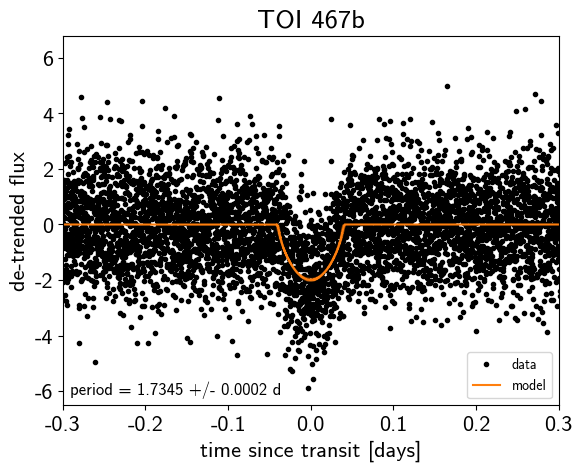

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

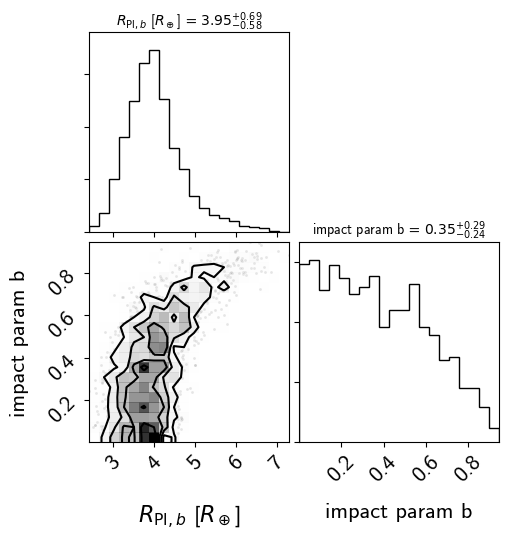

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

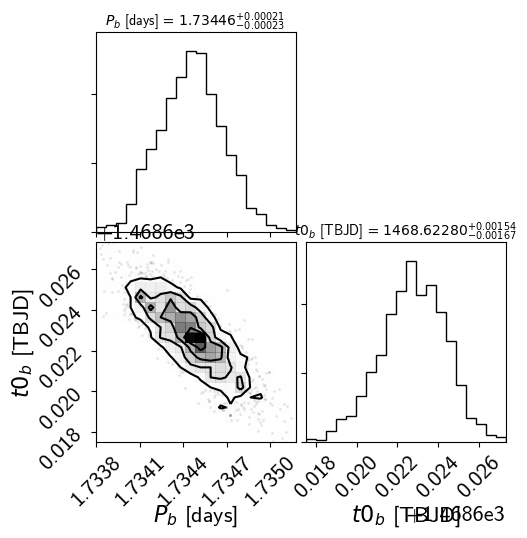

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

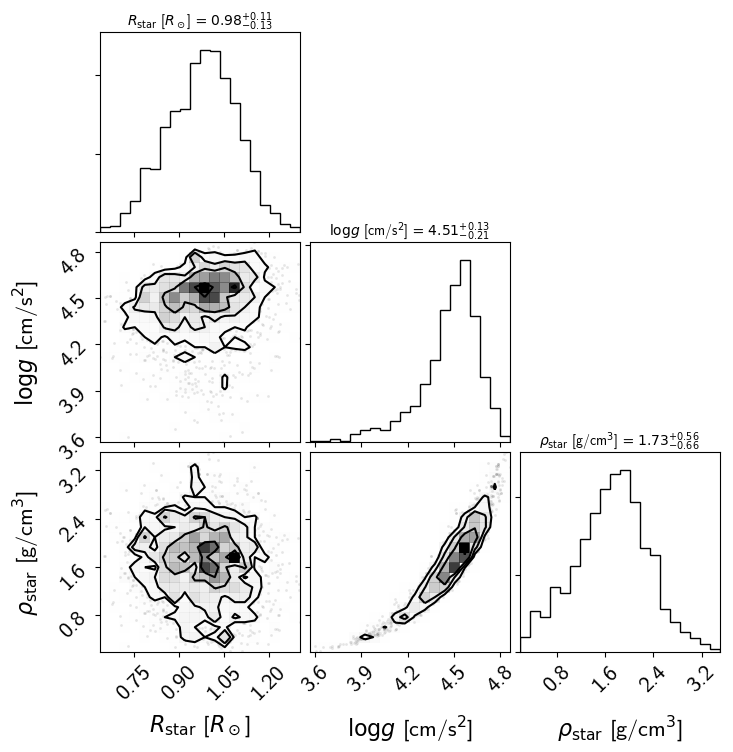

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3